In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btc-usd/btc_3m.csv
/kaggle/input/btc-usd/btc_1h (1).csv
/kaggle/input/btc-usd/btc_15m.csv
/kaggle/input/btc-usd/btc_30m.csv
/kaggle/input/btc-usd/btc_4h.csv
/kaggle/input/btc-usd/btc_6h.csv
/kaggle/input/btc-usd/btc_2h.csv
/kaggle/input/btc-usd/btc_5m.csv


In [18]:
# import ccxt
import pandas as pd
import datetime
import time

In [19]:
df = pd.read_csv('/kaggle/input/btc-usd/btc_5m.csv')
df.head()

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
1,2018-01-01 05:35:00,13600.00,13600.00,13501.01,13554.58,40.528679
2,2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536
3,2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614
4,2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135


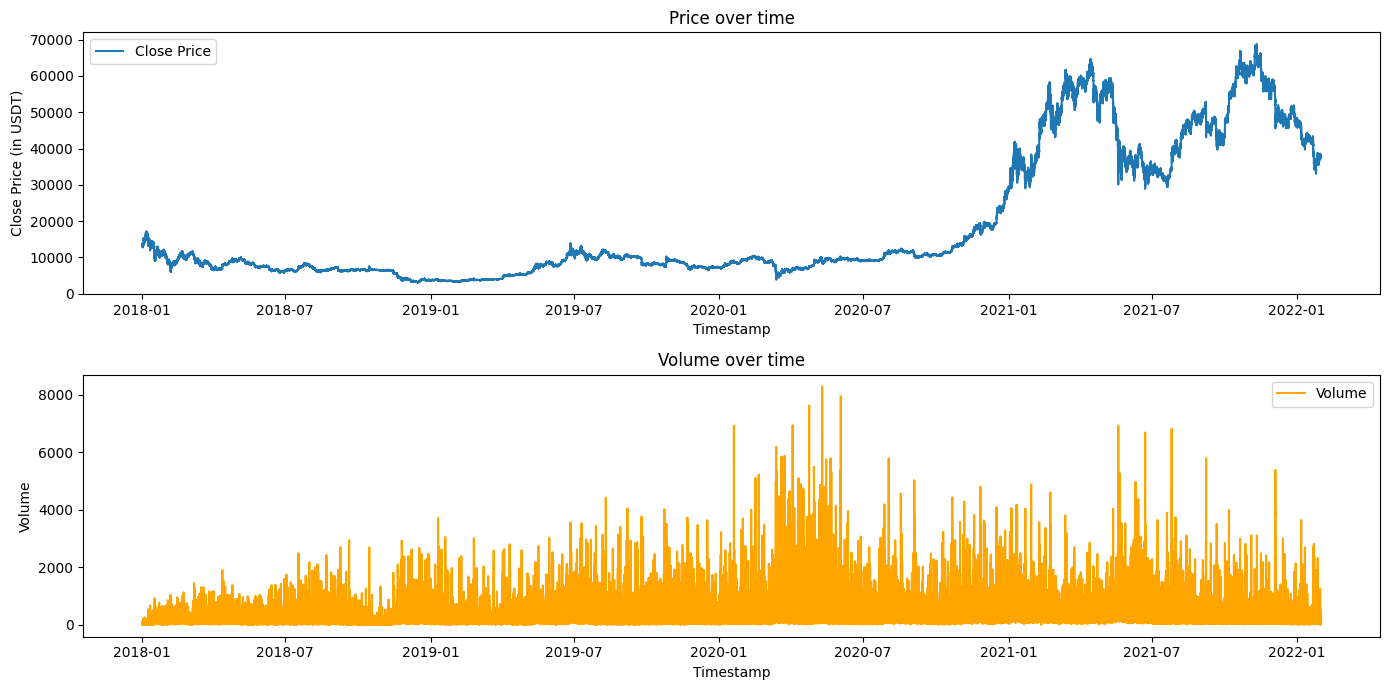

In [20]:
import matplotlib.pyplot as plt

# Convert 'timestamp' to datetime format if it's not already
df['datetime'] = pd.to_datetime(df['datetime'])

# Set 'timestamp' as the index of the DataFrame
df.set_index('datetime', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.title('Price over time')
plt.plot(df['close'], label='Close Price')
plt.xlabel('Timestamp')
plt.ylabel('Close Price (in USDT)')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Volume over time')
plt.plot(df['volume'], label='Volume', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd

# Add a new column with the shifted close prices to compare with
df['close_shifted'] = df['close'].shift(-1)

# Calculate the encoded 'price_movement' based on your conditions
df['price_movement'] = 1  # Initialize as no change
df.loc[df['close'] < df['close_shifted'], 'price_movement'] = 2  # Price goes up
df.loc[df['close'] > df['close_shifted'], 'price_movement'] = 0  # Price goes down

# Drop the 'close_shifted' as it was only used for the calculation
df.drop('close_shifted', axis=1, inplace=True)

In [54]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'price_movement'], dtype='object')

In [57]:
data = df.drop(columns = ['open','high', 'low', 'close','volume'])

In [58]:
data.head()

,price_movement
datetime,
2018-01-01 05:30:00,0
2018-01-01 05:35:00,2
2018-01-01 05:40:00,0
2018-01-01 05:45:00,2
2018-01-01 05:50:00,2


In [59]:
import torch
from torch.utils.data import Dataset

class PriceMovementDataset(Dataset):
    
    def __init__(self, split, data, length=10):
        assert split in {'train', 'test'}
        self.split = split
        self.data = data  # This is your encoded 'price_movement' series as a PyTorch tensor
        self.length = length  # Sequence length for training/testing

    def get_vocab_size(self):
        return 3
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1
    
    def __len__(self):
        return len(self.data) - self.length  # Adjust length to account for sequence length
    
    def __getitem__(self, idx):
        
        # Create sequences
        inp = self.data[idx:idx+self.length]
        sol = self.data[idx+1:idx+self.length+1]
        
        inp = inp.to_numpy()
        sol = sol.to_numpy()
        
        inp = torch.from_numpy(inp)
        sol = torch.from_numpy(sol)

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1

        return x, y

In [60]:
sp = int(0.9*df.shape[0])

In [73]:
train_dataset = PriceMovementDataset('train', data.price_movement[:sp])
test_dataset = PriceMovementDataset('test', data.price_movement[sp:])

In [74]:
!git clone https://github.com/karpathy/minGPT.git
%cd minGPT
!pip install -e .

Cloning into 'minGPT'...
remote: Enumerating objects: 489, done.
remote: Total 489 (delta 0), reused 0 (delta 0), pack-reused 489
Receiving objects: 100% (489/489), 1.44 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (261/261), done.
/kaggle/working/minGPT/minGPT/minGPT/minGPT/minGPT/minGPT
Obtaining file:///kaggle/working/minGPT/minGPT/minGPT/minGPT/minGPT/minGPT
  Preparing metadata (setup.py) ... done
  Attempting uninstall: minGPT
    Found existing installation: minGPT 0.0.1
    Uninstalling minGPT-0.0.1:
      Successfully uninstalled minGPT-0.0.1
  Running setup.py develop for minGPT


In [95]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.09M


In [100]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-6 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 15000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset)

running on device cpu


In [101]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.53613
iter_dt 35.20ms; iter 100: train loss 0.50788
iter_dt 39.63ms; iter 200: train loss 0.52117
iter_dt 50.18ms; iter 300: train loss 0.53628
iter_dt 36.47ms; iter 400: train loss 0.50409
iter_dt 39.11ms; iter 500: train loss 0.50795
iter_dt 35.35ms; iter 600: train loss 0.50356
iter_dt 33.11ms; iter 700: train loss 0.48935
iter_dt 35.75ms; iter 800: train loss 0.49086
iter_dt 36.82ms; iter 900: train loss 0.49184
iter_dt 34.17ms; iter 1000: train loss 0.48599
iter_dt 35.88ms; iter 1100: train loss 0.47382
iter_dt 37.37ms; iter 1200: train loss 0.47812
iter_dt 34.27ms; iter 1300: train loss 0.47796
iter_dt 34.28ms; iter 1400: train loss 0.47004
iter_dt 36.30ms; iter 1500: train loss 0.44771
iter_dt 33.73ms; iter 1600: train loss 0.46785
iter_dt 35.07ms; iter 1700: train loss 0.45158
iter_dt 39.25ms; iter 1800: train loss 0.45642
iter_dt 34.17ms; iter 1900: train loss 0.43862
iter_dt 39.12ms; iter 2000: train loss 0.43197
iter_dt 40.34ms; iter 2100

In [98]:
# now let's perform some evaluation
model.eval();
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)

def eval_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)
        # isolate the input pattern alone
        inp = x[:, :n]
        sol = y[:, -n:]
        # let the model sample the rest of the sequence
        cat = model.generate(inp, n, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, n:] # isolate the filled in sequence
        # compare the predicted sequence to the true sequence
        #print("sol: ", sol[10:15,-8:])
        #print("sol_candidate: ", sol_candidate[10:15,-8:])
        correct = (sol == sol_candidate).all(1).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
        #print("correct:",correct)
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            if not correct[i] and mistakes_printed_already < 3: # only print up to 5 mistakes to get a sense
                mistakes_printed_already += 1
                print("GPT claims that with %s the future price dynamics is %s but gt is %s" % (inp[i].tolist(), sol_candidate[i].tolist(), sol[i].tolist()))
        if max_batches is not None and b+1 >= max_batches:
            break
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_split(trainer, 'train', max_batches=50)
    test_score  = eval_split(trainer, 'test',  max_batches=50)

GPT claims that with [0, 2, 0, 2, 2, 0, 0, 2, 2, 0] the future price dynamics is [2, 0, 2, 2, 0, 2, 0, 2, 0, 2] but gt is [2, 0, 2, 2, 0, 0, 2, 2, 0, 0]
GPT claims that with [2, 0, 2, 2, 0, 0, 2, 2, 0, 0] the future price dynamics is [2, 0, 2, 0, 0, 2, 0, 2, 0, 2] but gt is [0, 2, 2, 0, 0, 2, 2, 0, 0, 0]
GPT claims that with [0, 2, 2, 0, 0, 2, 2, 0, 0, 0] the future price dynamics is [2, 2, 0, 2, 0, 2, 0, 2, 0, 2] but gt is [2, 2, 0, 0, 2, 2, 0, 0, 0, 0]
train final score: 45/5000 = 0.90% correct
GPT claims that with [2, 2, 2, 2, 0, 0, 2, 2, 2, 2] the future price dynamics is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2] but gt is [2, 2, 2, 0, 0, 2, 2, 2, 2, 0]
GPT claims that with [2, 2, 2, 0, 0, 2, 2, 2, 2, 0] the future price dynamics is [2, 2, 0, 2, 2, 0, 2, 0, 2, 0] but gt is [2, 2, 0, 0, 2, 2, 2, 2, 0, 2]
GPT claims that with [2, 2, 0, 0, 2, 2, 2, 2, 0, 2] the future price dynamics is [2, 0, 2, 0, 2, 0, 2, 0, 2, 0] but gt is [2, 0, 0, 2, 2, 2, 2, 0, 2, 2]
test final score: 42/5000 = 0.84% corre